# Forecasting with different solutions

We wil review the following options:

* SARIMA Model using Auto Arima
* Recurrent Neural Nets
* Convolutional Neural Nets
* Facebook's Prophet Library

The goal is to compare and find which one serves the best forecast and write a short article on each.

## Data Prep and Exploration 
*Note different model approaches might require a different data prep

In [2]:
install_dependencies = False
if install_dependencies:
    !pip install plotly==4.12.0
    !pip install pmdarima
    !pip install pystan
    !pip install fbprophet

In [3]:
#Import Data and Viz Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly
import plotly.express as px
import plotly.graph_objects as go

#Stats Library
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima import auto_arima # for determining ARIMA orders
from statsmodels.tsa.statespace.sarimax import SARIMAX

#Evaluation metrics
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse

#Facebook Prophet Libraries
from fbprophet import Prophet

#Tensorflow library
import tensorflow as tf

In [4]:
#Clean the currency column to make it a float
#The Revenue column is a string so we need to convert to floatdef clean_currency(x):
def clean_currency(x):
    """ If the value is a string, then remove currency symbol and delimiters
    otherwise, the value is numeric and can be converted
    """
    if isinstance(x, str):
        return(x.replace('£', '').replace(',', ''))
    return(x)

In [5]:
df = pd.read_csv("data/boohooman_20200701_20201031.csv")
df.head()

Date      Revenue
0  20200701  £310,125.53
1  20200702  £267,367.19
2  20200703  £259,462.99
3  20200704  £225,009.43
4  20200705  £256,431.46

In [6]:
#Convert Date column to timestamp
df.set_index('Date',inplace=True)
df.head()

Revenue
Date                 
20200701  £310,125.53
20200702  £267,367.19
20200703  £259,462.99
20200704  £225,009.43
20200705  £256,431.46

In [7]:
df.index = pd.to_datetime(df.index,format="%Y%m%d")
df.head()

Revenue
Date                   
2020-07-01  £310,125.53
2020-07-02  £267,367.19
2020-07-03  £259,462.99
2020-07-04  £225,009.43
2020-07-05  £256,431.46

In [8]:
#Convert Revenue column to Float
df["Revenue"] = df['Revenue'].apply(clean_currency).astype('float')

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 123 entries, 2020-07-01 to 2020-10-31
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Revenue  123 non-null    float64
dtypes: float64(1)
memory usage: 1.9 KB


## Data Visualization

### Line plot

/opt/conda/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




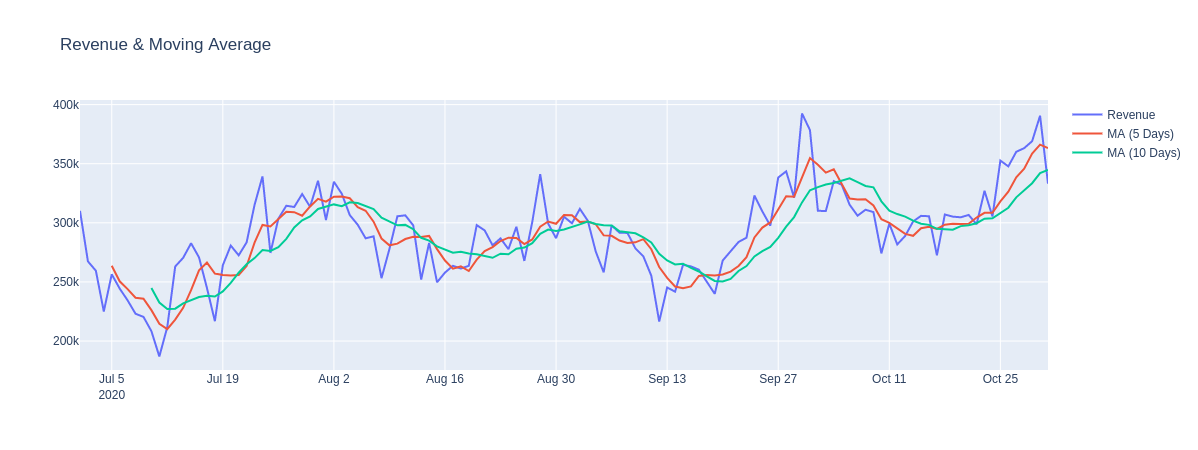

In [10]:
#fig = px.line(df,x=df.index,y=["Revenue",df.Revenue.rolling(10).mean()],title="Time Series Revenue Range")
fig = go.Figure()
fig.add_trace(go.Line(x=df.index,y=df["Revenue"],name="Revenue"))
fig.add_trace(go.Line(x=df.index,y=df.Revenue.rolling(5).mean(),name="MA (5 Days)"))
fig.add_trace(go.Line(x=df.index,y=df.Revenue.rolling(10).mean(),name="MA (10 Days)"))
fig.update_layout(title="Revenue & Moving Average")
fig.show()
#fig2 = px.line(df.Revenue.rolling(10).mean(),x=df.index,y="Revenue")

#fig2.show()

In [11]:
#Adding the day of the week to see if there are specific days when the revenue increase
df["week_day"] = list(pd.Series(df.index).dt.day_name())
df.head()

Revenue   week_day
Date                            
2020-07-01  310125.53  Wednesday
2020-07-02  267367.19   Thursday
2020-07-03  259462.99     Friday
2020-07-04  225009.43   Saturday
2020-07-05  256431.46     Sunday

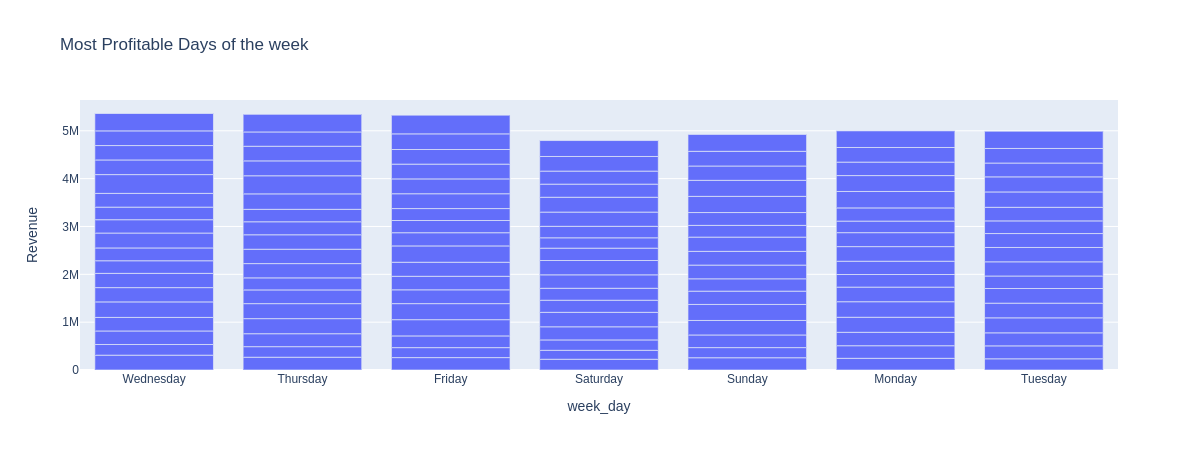

In [12]:
fig = px.bar(df,x="week_day",y="Revenue",title="Most Profitable Days of the week")
fig.show()

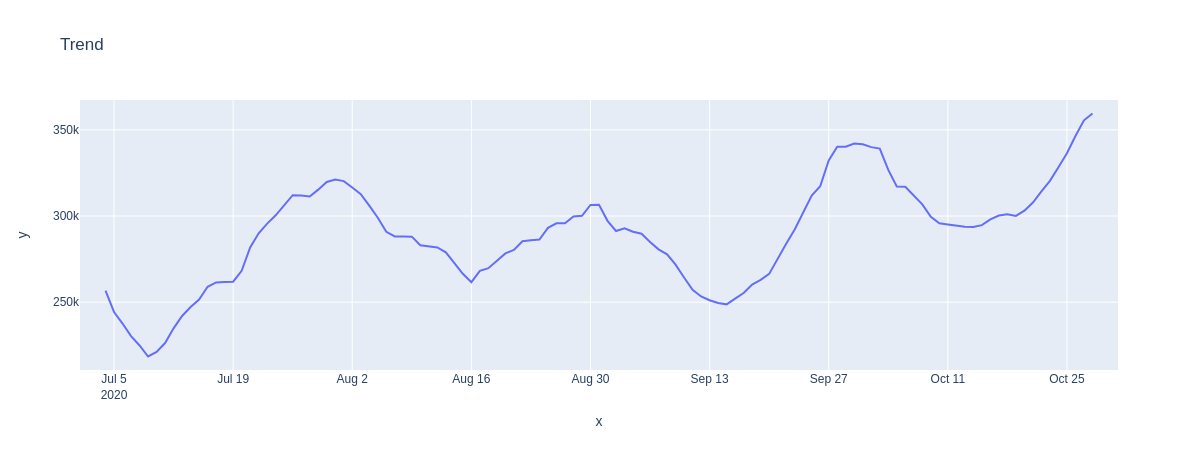

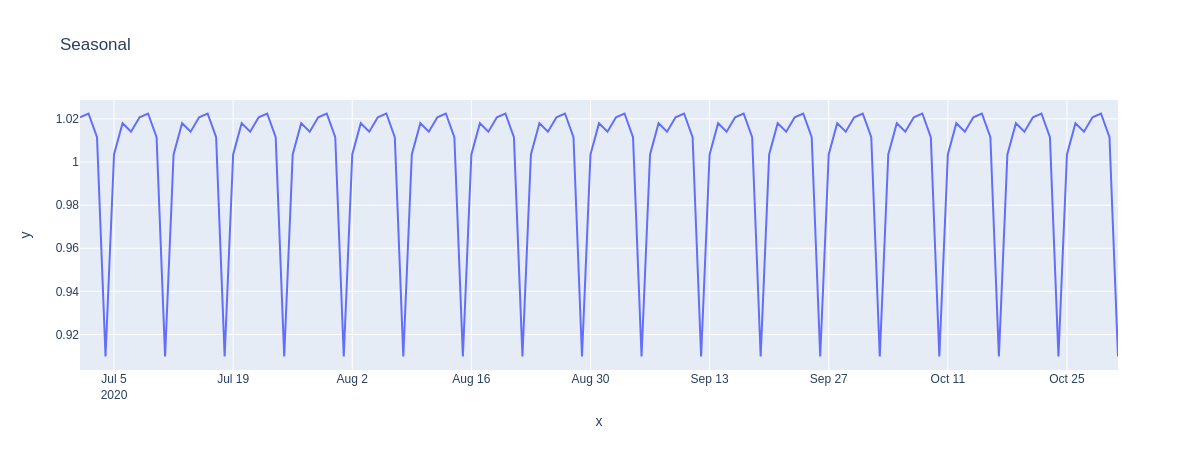

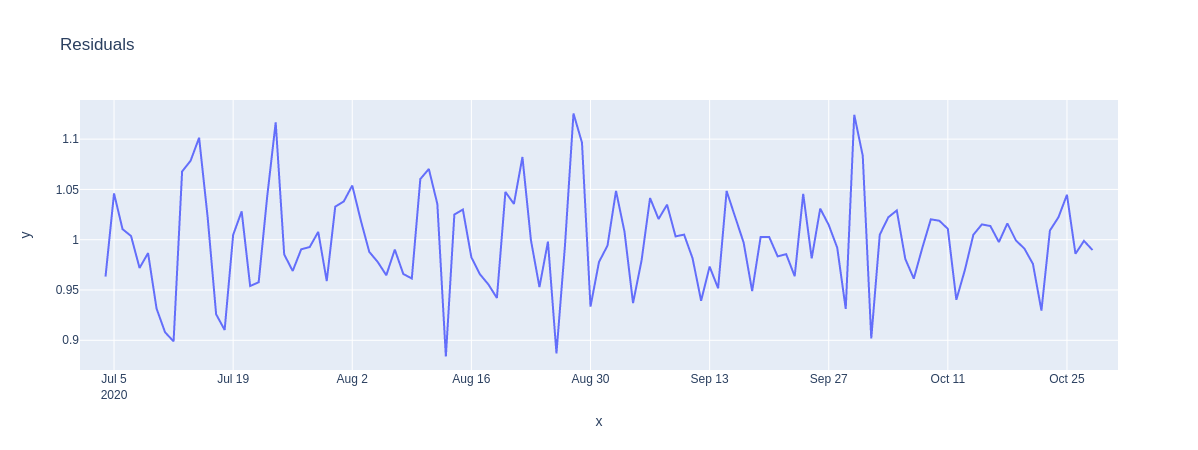

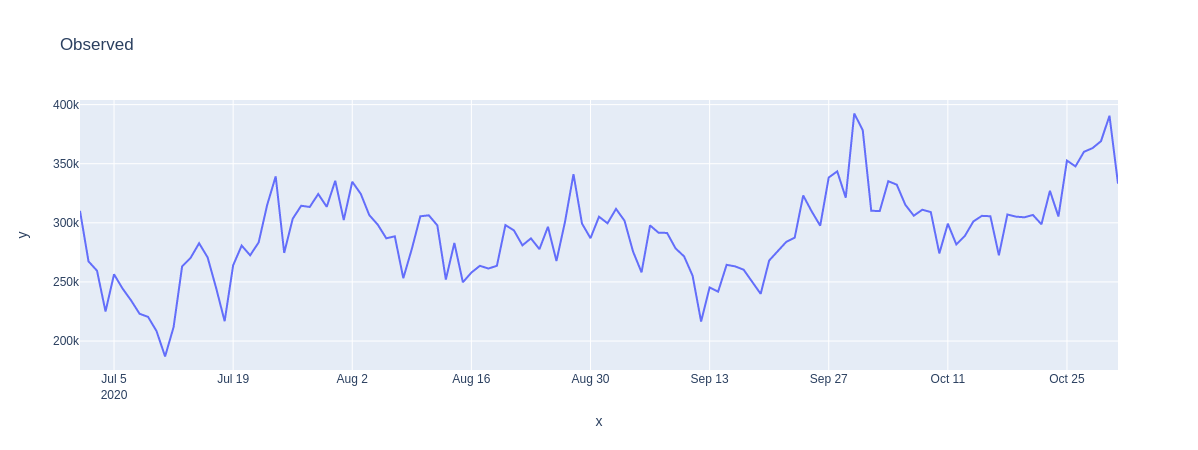

In [13]:
results = seasonal_decompose(df["Revenue"],model="mutliplicative")
fig1 = px.line(results.trend,x=df.index,y=results.trend, title="Trend")
fig2 = px.line(results.seasonal,x=df.index,y=results.seasonal, title="Seasonal")
fig3 = px.line(results.resid,x=df.index,y=results.resid, title="Residuals")
fig4 = px.line(results.observed,x=df.index,y=results.observed, title="Observed")
fig1.show()
fig2.show()
fig3.show()
fig4.show()

## SARIMA Model

This is a time series forecasting technique called *Seasonal Autoregressive Integrated Moving Average Exogenous*, it is similar to *Autogressive Inegrated Moving Average Exogenous* but it included another set of parameters for P,D, Q which are for seasonality. 

We can some from the *Seasonal* plot above that there is some seasonality. This means we might need to account for seasonality. Even in the *Observed* plot we see some seasonality but not a great deal. This means we will need to add some differencing to help idenitify seasonality. 

I am going to use the auto_arima library to determine the right values for PDQ.

In [14]:
auto_arima(df["Revenue"],seasonal=True,m=7).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                                  y   No. Observations:                  123
Model:             SARIMAX(1, 1, 1)x(2, 0, [], 7)   Log Likelihood               -1393.314
Date:                            Sat, 12 Dec 2020   AIC                           2796.628
Time:                                    09:00:41   BIC                           2810.648
Sample:                                         0   HQIC                          2802.322
                                            - 123                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4653      0.220      2.116      0.034       0.034       0.896
ma.L1         -0.6649      0.173     -3.841      0.000      -1.004      -0.326
ar.S.L7        0.0877      0.039      2.223      0.026       0.010       0.165
ar.S.L14       0.1263      0.078      1.612      0.107      -0.027       0.280
sigma2      5.195e+08   1.81e-10   2.86e+18      0.000     5.2e+08     5.2e+08
===================================================================================
Ljung-Box (Q):                       63.23   Jarque-Bera (JB):                 1.00
Prob(Q):                              0.01   Prob(JB):                         0.61
Heteroskedasticity (H):               1.06   Skew:                             0.11
Prob(H) (two-sided):                  0.86   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 4.22e+33. Standard errors may be unstable.
"""

In [15]:
#Split the dataset
sarima_train = df.iloc[:90]
sarima_test = df.iloc[90:]

In [16]:
sarima_model = SARIMAX(sarima_train["Revenue"],order=(1,1,1),seasonal_order=(2,0,0,7))
sarima_results = sarima_model.fit()
sarima_results.summary()

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.

/opt/conda/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning:

No frequency information was provided, so inferred frequency D will be used.



<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                            Revenue   No. Observations:                   90
Model:             SARIMAX(1, 1, 1)x(2, 0, [], 7)   Log Likelihood               -1013.186
Date:                            Sat, 12 Dec 2020   AIC                           2036.372
Time:                                    09:00:42   BIC                           2048.815
Sample:                                07-01-2020   HQIC                          2041.388
                                     - 09-28-2020                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5523      0.262      2.105      0.035       0.038       1.067
ma.L1         -0.7201      0.209     -3.453      0.001      -1.129      -0.311
ar.S.L7        0.0666      0.047      1.428      0.153      -0.025       0.158
ar.S.L14       0.1143      0.080      1.434      0.152      -0.042       0.271
sigma2      4.825e+08      2e-10   2.41e+18      0.000    4.83e+08    4.83e+08
===================================================================================
Ljung-Box (Q):                       69.99   Jarque-Bera (JB):                 0.63
Prob(Q):                              0.00   Prob(JB):                         0.73
Heteroskedasticity (H):               0.60   Skew:                             0.12
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.67
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 2.44e+34. Standard errors may be unstable.
"""

In [17]:
#Getting start and end dates fro model
start = len(sarima_train)
end = start + len(sarima_test) - 1

In [18]:
sarima_predictions = sarima_results.predict(start=start,end=end,typ="levels").rename("SARIMA(1,1,1)")

/opt/conda/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




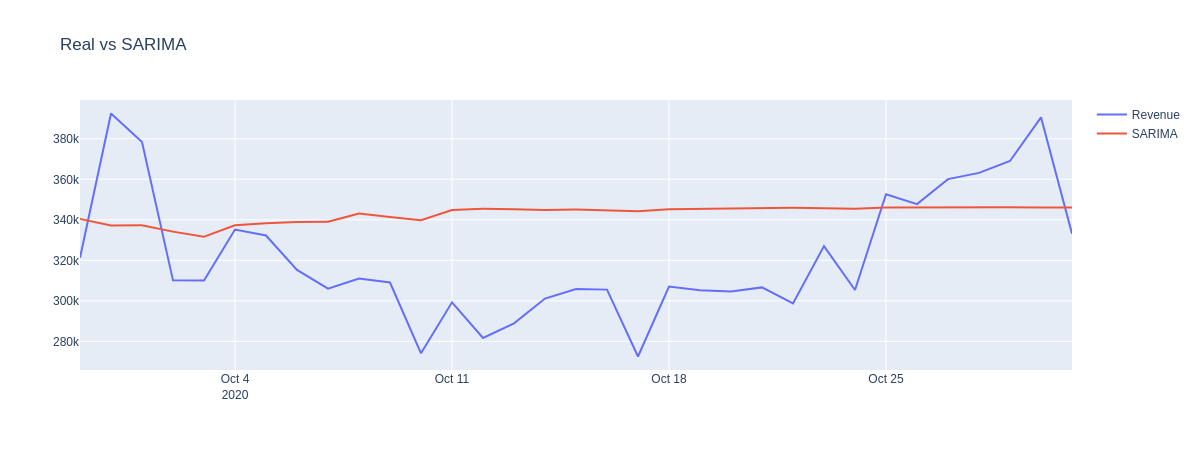

In [19]:
#Ploting results
fig = go.Figure()
fig.add_trace(go.Line(x=df.index[90:],y=df["Revenue"].iloc[90:],name="Revenue"))
fig.add_trace(go.Line(x=sarima_predictions.index,y=sarima_predictions,name="SARIMA"))
fig.update_layout(title="Real vs SARIMA")
fig.show()

## Facebook's Prophet Library

This is a open source library from Facebook which is a procedure for time series forecasting on additive model where there are non-linear trends.

It is meant to be fast, accurate, automated and tunable to your data.

Facebook's prophets requires specifics values for the columns and only two columns Datetime & Target Variable.

In [20]:
#Removing the weekend day column
df_fb = df.copy()
df_fb.drop(columns="week_day",axis=1,inplace=True)
df_fb.head()

Revenue
Date                 
2020-07-01  310125.53
2020-07-02  267367.19
2020-07-03  259462.99
2020-07-04  225009.43
2020-07-05  256431.46

In [21]:
#Converting date index back into date
df_fb["ds"] = df.index
df_fb.head()

Revenue         ds
Date                            
2020-07-01  310125.53 2020-07-01
2020-07-02  267367.19 2020-07-02
2020-07-03  259462.99 2020-07-03
2020-07-04  225009.43 2020-07-04
2020-07-05  256431.46 2020-07-05

In [22]:
df_fb.columns=["y","ds"]
df_fb.head()

y         ds
Date                            
2020-07-01  310125.53 2020-07-01
2020-07-02  267367.19 2020-07-02
2020-07-03  259462.99 2020-07-03
2020-07-04  225009.43 2020-07-04
2020-07-05  256431.46 2020-07-05

In [23]:
df_fb.reset_index(inplace=True)

In [24]:
df_fb.drop(columns="Date",axis=1,inplace=True)
df_fb.head()

y         ds
0  310125.53 2020-07-01
1  267367.19 2020-07-02
2  259462.99 2020-07-03
3  225009.43 2020-07-04
4  256431.46 2020-07-05

In [25]:
#Date column or ds needs to be a datetime object
df_fb["ds"] = pd.to_datetime(df_fb["ds"])
df_fb.head()

y         ds
0  310125.53 2020-07-01
1  267367.19 2020-07-02
2  259462.99 2020-07-03
3  225009.43 2020-07-04
4  256431.46 2020-07-05

In [26]:
#Forecasting with no train test split
fb_model = Prophet()
fb_model.fit(df_fb)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


In [27]:
#Forecast into the future
future = fb_model.make_future_dataframe(periods=30) #predicting 30 days into the future

In [28]:
future

ds
0   2020-07-01
1   2020-07-02
2   2020-07-03
3   2020-07-04
4   2020-07-05
..         ...
148 2020-11-26
149 2020-11-27
150 2020-11-28
151 2020-11-29
152 2020-11-30

[153 rows x 1 columns]

In [29]:
forecast = fb_model.predict(future)

In [30]:
forecast

ds          trend     yhat_lower     yhat_upper    trend_lower  \
0   2020-07-01  259884.163223  231290.180130  303119.793774  259884.163223   
1   2020-07-02  260353.553978  229446.520245  304937.951899  260353.553978   
2   2020-07-03  260822.944733  225711.513367  304694.061465  260822.944733   
3   2020-07-04  261292.335488  199621.609020  272406.974609  261292.335488   
4   2020-07-05  261761.726243  222873.482318  300247.150419  261761.726243   
..         ...            ...            ...            ...            ...   
148 2020-11-26  347139.416097  318986.458371  392162.967052  346525.308905   
149 2020-11-27  347856.758232  314617.097747  390946.009799  347194.485878   
150 2020-11-28  348574.100366  285383.533078  360941.525538  347853.842504   
151 2020-11-29  349291.442501  309626.143082  385784.427997  348523.104800   
152 2020-11-30  350008.784635  316440.269824  391892.471202  349201.657750   

       trend_upper  additive_terms  additive_terms_lower  \
0    259884.163223     7968.043607           7968.043607   
1    260353.553978     6485.030289           6485.030289   
2    260822.944733     4900.221182           4900.221182   
3    261292.335488   -25054.802543         -25054.802543   
4    261761.726243     -312.693985           -312.693985   
..             ...             ...                   ...   
148  347724.441765     6485.030289           6485.030289   
149  348476.494469     4900.221182           4900.221182   
150  349231.567289   -25054.802543         -25054.802543   
151  349989.871783     -312.693985           -312.693985   
152  350743.613431     3517.613159           3517.613159   

     additive_terms_upper        weekly  weekly_lower  weekly_upper  \
0             7968.043607   7968.043607   7968.043607   7968.043607   
1             6485.030289   6485.030289   6485.030289   6485.030289   
2             4900.221182   4900.221182   4900.221182   4900.221182   
3           -25054.802543 -25054.802543 -25054.802543 -25054.802543   
4             -312.693985   -312.693985   -312.693985   -312.693985   
..                    ...           ...           ...           ...   
148           6485.030289   6485.030289   6485.030289   6485.030289   
149           4900.221182   4900.221182   4900.221182   4900.221182   
150         -25054.802543 -25054.802543 -25054.802543 -25054.802543   
151           -312.693985   -312.693985   -312.693985   -312.693985   
152           3517.613159   3517.613159   3517.613159   3517.613159   

     multiplicative_terms  multiplicative_terms_lower  \
0                     0.0                         0.0   
1                     0.0                         0.0   
2                     0.0                         0.0   
3                     0.0                         0.0   
4                     0.0                         0.0   
..                    ...                         ...   
148                   0.0                         0.0   
149                   0.0                         0.0   
150                   0.0                         0.0   
151                   0.0                         0.0   
152                   0.0                         0.0   

     multiplicative_terms_upper           yhat  
0                           0.0  267852.206831  
1                           0.0  266838.584267  
2                           0.0  265723.165916  
3                           0.0  236237.532946  
4                           0.0  261449.032258  
..                          ...            ...  
148                         0.0  353624.446387  
149                         0.0  352756.979414  
150                         0.0  323519.297824  
151                         0.0  348978.748516  
152                         0.0  353526.397794  

[153 rows x 16 columns]

In [31]:
forecast[['ds','yhat_lower','yhat_upper','yhat']]

ds     yhat_lower     yhat_upper           yhat
0   2020-07-01  231290.180130  303119.793774  267852.206831
1   2020-07-02  229446.520245  304937.951899  266838.584267
2   2020-07-03  225711.513367  304694.061465  265723.165916
3   2020-07-04  199621.609020  272406.974609  236237.532946
4   2020-07-05  222873.482318  300247.150419  261449.032258
..         ...            ...            ...            ...
148 2020-11-26  318986.458371  392162.967052  353624.446387
149 2020-11-27  314617.097747  390946.009799  352756.979414
150 2020-11-28  285383.533078  360941.525538  323519.297824
151 2020-11-29  309626.143082  385784.427997  348978.748516
152 2020-11-30  316440.269824  391892.471202  353526.397794

[153 rows x 4 columns]

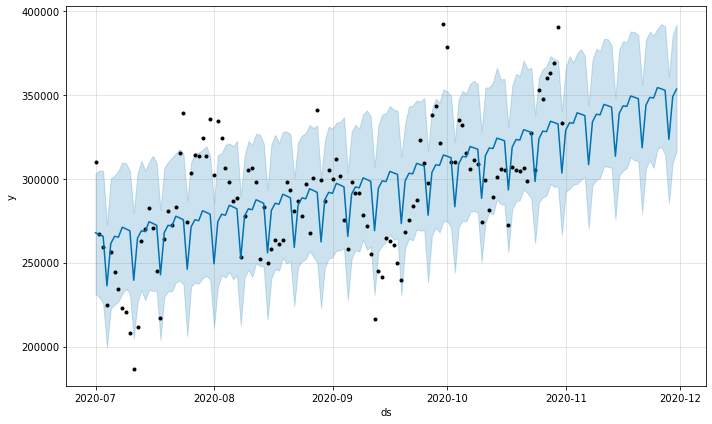

In [32]:
fb_model.plot(forecast); #At thist stage we are predicting until the end of the year but we want to  test

In [33]:
#Create prophets train and test  datasets
fb_train = df_fb.iloc[:90]
fb_test = df_fb.iloc[90:]

In [34]:
fb_prophet_model = Prophet(seasonality_mode="multiplicative",weekly_seasonality=True)
fb_prophet_model.fit(fb_train)
prophet_future = fb_prophet_model.make_future_dataframe(periods=33,freq="D")
prophet_forecast = fb_prophet_model.predict(prophet_future)

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


/opt/conda/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




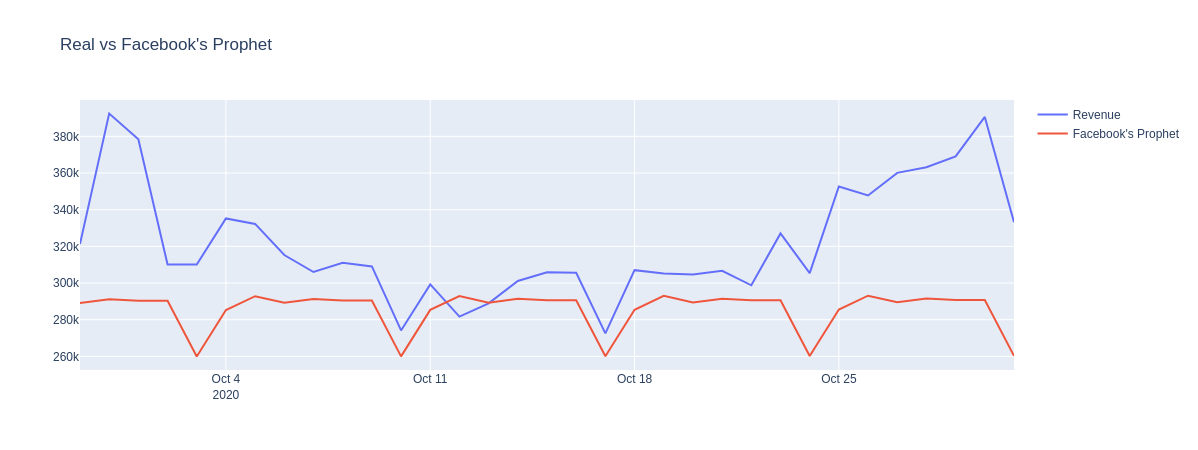

In [35]:
#Ploting results
fig = go.Figure()
fig.add_trace(go.Line(x=df.index[90:],y=df["Revenue"].iloc[90:],name="Revenue"))
fig.add_trace(go.Line(x=prophet_forecast["ds"].iloc[90:],y=prophet_forecast["yhat"].iloc[90:],name="Facebook's Prophet"))
fig.update_layout(title="Real vs Facebook's Prophet")
fig.show()

In [36]:
#Prophets includes their own evaluation diagnonstics
from fbprophet.diagnostics import cross_validation, performance_metrics
from fbprophet.plot import plot_cross_validation_metric

In [37]:
#INTIAL
initial = str(30) + ' days'
#PERIOD
period = str(10) + ' days'
#HORIZON
horizon = str(5) + ' days'

In [38]:
fb_cv = cross_validation(fb_prophet_model,initial= initial, period=period,horizon=horizon)

INFO:fbprophet:Making 6 forecasts with cutoffs between 2020-08-04 00:00:00 and 2020-09-23 00:00:00


In [39]:
fb_cv.head()

ds           yhat     yhat_lower     yhat_upper          y  \
0 2020-08-05  348092.504694  316128.108638  378622.671420  298387.24   
1 2020-08-06  340417.709740  309526.191115  371225.242373  286876.16   
2 2020-08-07  341631.105777  309824.297600  372279.902511  288568.58   
3 2020-08-08  296243.017178  261924.039126  326397.855872  253175.06   
4 2020-08-09  335639.778339  302655.732540  367443.139621  277877.36   

      cutoff  
0 2020-08-04  
1 2020-08-04  
2 2020-08-04  
3 2020-08-04  
4 2020-08-04

In [40]:
performance_metrics(fb_cv)

horizon           mse          rmse           mae      mape     mdape  \
0  1 days  1.540347e+09  39247.248522  36420.828952  0.130521  0.140205   
1  2 days  1.420269e+09  37686.456060  34472.561554  0.125240  0.108078   
2  3 days  1.812044e+09  42568.111292  36059.887890  0.128489  0.139582   
3  4 days  2.418562e+09  49178.882545  44598.386510  0.152139  0.162043   
4  5 days  2.787603e+09  52797.755594  48571.010222  0.168927  0.180007   

   coverage  
0  0.500000  
1  0.500000  
2  0.500000  
3  0.333333  
4  0.166667

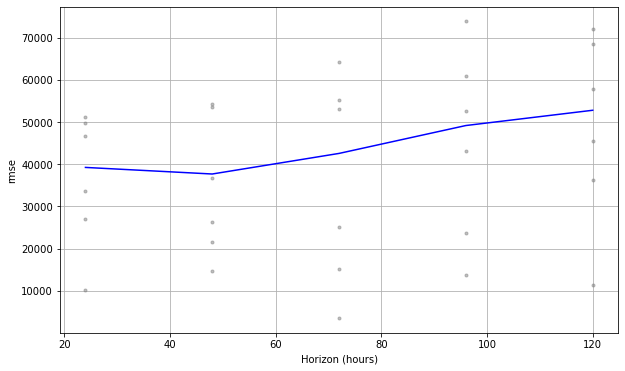

In [41]:
plot_cross_validation_metric(fb_cv,metric='rmse');

## Tensorflow Recurrent Neural Nets

Recurrents Neural Nets are useful for time series analysis because it can look back at the previous step and the current step before it makes it predictions. 

In [42]:
df_tf = df.copy()
df_tf.head()

Revenue   week_day
Date                            
2020-07-01  310125.53  Wednesday
2020-07-02  267367.19   Thursday
2020-07-03  259462.99     Friday
2020-07-04  225009.43   Saturday
2020-07-05  256431.46     Sunday

In [43]:
#Create train and test split
tf_train = df_tf[['Revenue']].iloc[:90]
tf_test = df_tf[['Revenue']].iloc[90:]

In [44]:
#Scale the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [45]:
standard_scaler = StandardScaler()
minmax_scaler = MinMaxScaler()

standard_train = standard_scaler.fit_transform(tf_train)
minmax_train = minmax_scaler.fit_transform(tf_train)

standard_test = standard_scaler.fit_transform(tf_test)
minmax_test = minmax_scaler.fit_transform(tf_test)

### Using a TimeseriesGenerator

In [46]:
from keras.preprocessing.sequence import TimeseriesGenerator

Using TensorFlow backend.


In [47]:
n_inputs = 12
n_features = 1

timeseries_gen = TimeseriesGenerator(standard_train,standard_train,length=n_inputs,batch_size=1)

In [48]:
X, y = timeseries_gen[0]
X.shape

(1, 12, 1)

In [49]:
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('loss')<0.01):
            print("\nReached acceptable loss!")
            self.model.stop_training = True

In [50]:
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import LSTM

In [51]:
tf_model = Sequential()
tf_model.add(LSTM(600,activation='relu',input_shape=(n_inputs,n_features)))
tf_model.add(Dense(1))
tf_model.compile(optimizer='adam',loss='mse')

In [52]:
tf_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 600)               1444800   
_________________________________________________________________
dense (Dense)                (None, 1)                 601       
Total params: 1,445,401
Trainable params: 1,445,401
Non-trainable params: 0
_________________________________________________________________


In [53]:
callback = myCallback()
tf_model.fit_generator(timeseries_gen,epochs=100,callbacks=[callback])

Instructions for updating:
Please use Model.fit, which supports generators.


Instructions for updating:
Please use Model.fit, which supports generators.


Epoch 1/100
78/78 [==============================] - 4s 52ms/step - loss: 0.6474
Epoch 2/100
78/78 [==============================] - 4s 49ms/step - loss: 0.5813
Epoch 3/100
78/78 [==============================] - 4s 49ms/step - loss: 0.5020
Epoch 4/100
78/78 [==============================] - 4s 49ms/step - loss: 0.5789
Epoch 5/100
78/78 [==============================] - 4s 48ms/step - loss: 0.4859
Epoch 6/100
78/78 [==============================] - 4s 48ms/step - loss: 0.4791
Epoch 7/100
78/78 [==============================] - 4s 47ms/step - loss: 0.4920
Epoch 8/100
78/78 [==============================] - 4s 48ms/step - loss: 0.4543
Epoch 9/100
78/78 [==============================] - 4s 47ms/step - loss: 0.4439
Epoch 10/100
78/78 [==============================] - 4s 49ms/step - loss: 0.4473
Epoch 11/100
78/78 [==============================] - 4s 46ms/step - loss: 0.4206
Epoch 12/100
78/78 [==============================] - 4s 46ms/step - loss: 0.4257
Epoch 13/100
78/78 [=====

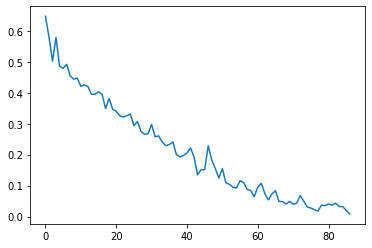

In [54]:
tf_loss = tf_model.history.history["loss"]
plt.plot(range(len(tf_loss)),tf_loss)

In [55]:
#first_eval_batch = standard_train[-2:]

In [56]:
#first_eval_batch = first_eval_batch.reshape(1,n_inputs,n_features)

In [57]:
#tf_model.predict(first_eval_batch)

In [58]:
#standard_train[-2:]

In [86]:
current_batch[0]

array([[-0.5745532 ],
       [-0.89844556],
       [-1.19934123],
       [-0.33765344],
       [-0.10479889],
       [ 0.14295059],
       [ 0.25382793],
       [ 1.34529874],
       [ 0.93308628],
       [ 0.56417028],
       [ 1.81009439],
       [ 1.96956995]])

In [102]:
tf_timeseries_pred = []

first_eval_batch = standard_train[-n_inputs:]
current_batch = first_eval_batch.reshape((1,n_inputs,n_features))

for i in range(len(standard_test)):
    
    current_pred = tf_model.predict(current_batch)[0]
    
    tf_timeseries_pred.append(current_pred)
    
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

In [60]:
tf_inverted_preds = standard_scaler.inverse_transform(tf_timeseries_pred)
tf_inverted_preds

array([[361194.94],
       [366319.03],
       [383984.16],
       [377911.  ],
       [361230.44],
       [352727.88],
       [336229.4 ],
       [326637.56],
       [316821.84],
       [321693.75],
       [355773.56],
       [357437.53],
       [340927.47],
       [332358.47],
       [338683.62],
       [334982.97],
       [308978.78],
       [313844.84],
       [332022.03],
       [316404.34],
       [319724.5 ],
       [313631.44],
       [300170.22],
       [286219.34],
       [282579.72],
       [303696.38],
       [308659.34],
       [310981.7 ],
       [302057.53],
       [295494.06],
       [286443.47],
       [299469.94],
       [307815.38]], dtype=float32)

/opt/conda/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




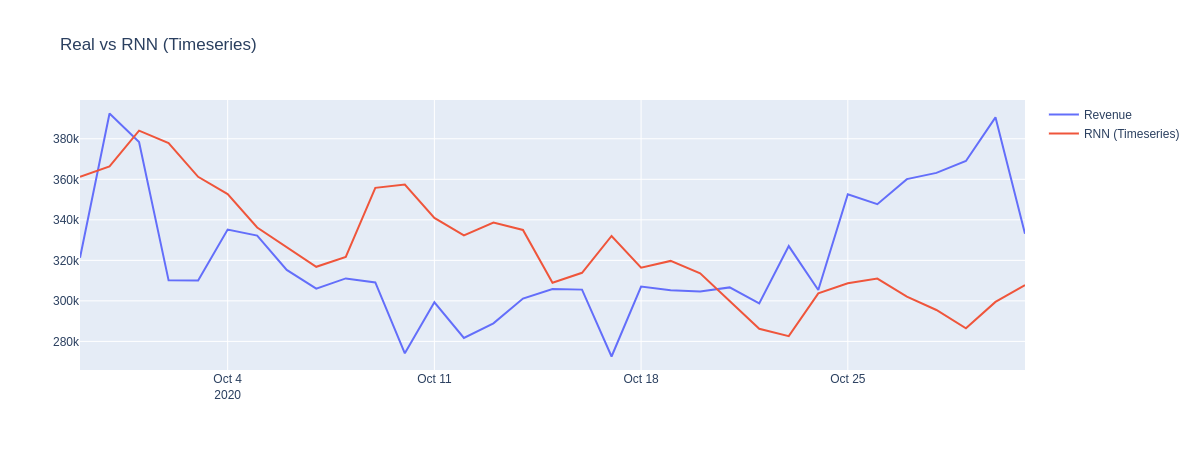

In [61]:
#Ploting results
fig = go.Figure()
fig.add_trace(go.Line(x=df.index[90:],y=df["Revenue"].iloc[90:],name="Revenue"))
fig.add_trace(go.Line(x=df_tf.index[90:],y=tf_inverted_preds.flatten(),name="RNN (Timeseries)"))
fig.update_layout(title="Real vs RNN (Timeseries)")
fig.show()

## Tensorflow Convolution Neural Net

In [87]:
conv_model = tf.keras.Sequential([
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(3,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32, activation='relu'),
    tf.keras.layers.Conv1D(filters=32,
                           kernel_size=(3,),
                           activation='relu'),
    tf.keras.layers.Dense(units=32),
    tf.keras.layers.Dense(units=1),
])

In [88]:
tf_train["Revenue"]

Date
2020-07-01    310125.53
2020-07-02    267367.19
2020-07-03    259462.99
2020-07-04    225009.43
2020-07-05    256431.46
                ...    
2020-09-24    323111.48
2020-09-25    309631.98
2020-09-26    297568.29
2020-09-27    338310.47
2020-09-28    343525.38
Name: Revenue, Length: 90, dtype: float64

In [89]:
conv_model.compile(optimizer="adam",loss="mse")

In [90]:
conv_model.fit_generator(timeseries_gen,epochs=100,callbacks=[callback])

Epoch 1/100
78/78 [==============================] - 0s 6ms/step - loss: 0.7135
Epoch 2/100
78/78 [==============================] - 0s 6ms/step - loss: 0.6437
Epoch 3/100
78/78 [==============================] - 0s 4ms/step - loss: 0.6381
Epoch 4/100
78/78 [==============================] - 1s 7ms/step - loss: 0.6123
Epoch 5/100
78/78 [==============================] - 1s 7ms/step - loss: 0.6204
Epoch 6/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5853
Epoch 7/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5655
Epoch 8/100
78/78 [==============================] - 1s 7ms/step - loss: 0.5712
Epoch 9/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5342
Epoch 10/100
78/78 [==============================] - 0s 6ms/step - loss: 0.5198
Epoch 11/100
78/78 [==============================] - 1s 8ms/step - loss: 0.4943
Epoch 12/100
78/78 [==============================] - 1s 8ms/step - loss: 0.4661
Epoch 13/100
78/78 [=================

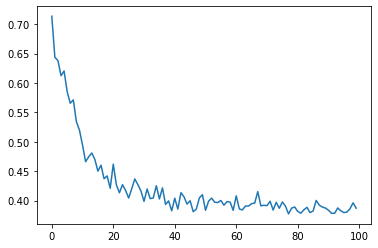

In [91]:
conv_loss = conv_model.history.history["loss"]
plt.plot(range(len(conv_loss)),conv_loss)

In [115]:
conv_eval_batch = standard_train[-n_inputs:]
conv_current_batch = first_eval_batch.reshape((1,n_inputs,n_features))

In [132]:
conv_current_batch_1 = np.append(conv_current_batch[:,1:,:],[[[.89]]],axis=1)
#conv_current_batch[:,1:,:].ndim

In [153]:
conv_eval_batch = standard_train[-n_inputs:]
conv_current_batch = first_eval_batch.reshape((1,n_inputs,n_features))
conv_timeseries_pred = []

for i in range(len(standard_test)):
    
    current_pred = conv_model.predict(current_batch)
    #Flatten 3d to 1
    append_pred = np.matrix.flatten(current_pred)[-1]
    conv_timeseries_pred.append(append_pred)
    #conv_timeseries_pred.append(current_pred)
        
    current_batch = np.append(current_batch[:,1:,:],[[[append_pred]]],axis=1)

In [156]:
new_preds = [[[conv_timeseries_pred]]]

In [157]:
#conv_inverted_preds = standard_scaler.inverse_transform(conv_timeseries_pred)
conv_inverted_preds = standard_scaler.inverse_transform(new_preds)

In [158]:
conv_inverted_preds

array([[[[324158.84, 327302.34, 342081.1 , 353009.  , 352384.34,
          348389.6 , 339593.  , 331550.38, 323345.34, 311663.6 ,
          298870.72, 292059.7 , 306689.2 , 324282.9 , 341619.47,
          337125.44, 342072.16, 318187.7 , 307562.7 , 293047.5 ,
          293225.25, 309672.03, 330082.38, 335898.06, 342767.9 ,
          337708.97, 320904.78, 315231.5 , 306122.44, 292551.06,
          300462.47, 316764.1 , 336086.8 ]]]], dtype=float32)

/opt/conda/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




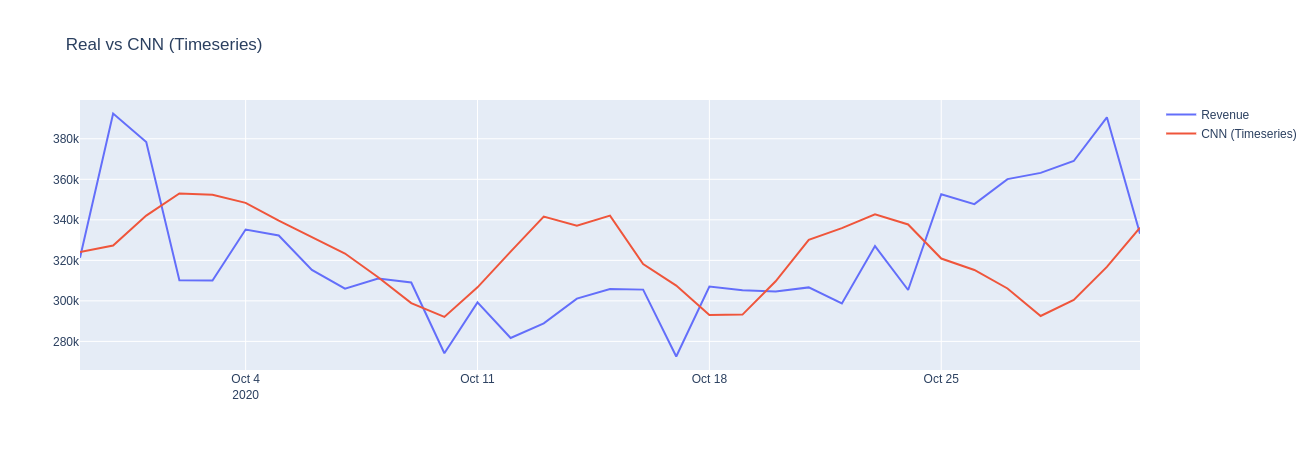

In [159]:
#Ploting results
fig = go.Figure()
fig.add_trace(go.Line(x=df.index[90:],y=df["Revenue"].iloc[90:],name="Revenue"))
fig.add_trace(go.Line(x=df_tf.index[90:],y=conv_inverted_preds.flatten(),name="CNN (Timeseries)"))
fig.update_layout(title="Real vs CNN (Timeseries)")
fig.show()

## Comparing Model Performance

/opt/conda/lib/python3.7/site-packages/plotly/graph_objs/_deprecations.py:385: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




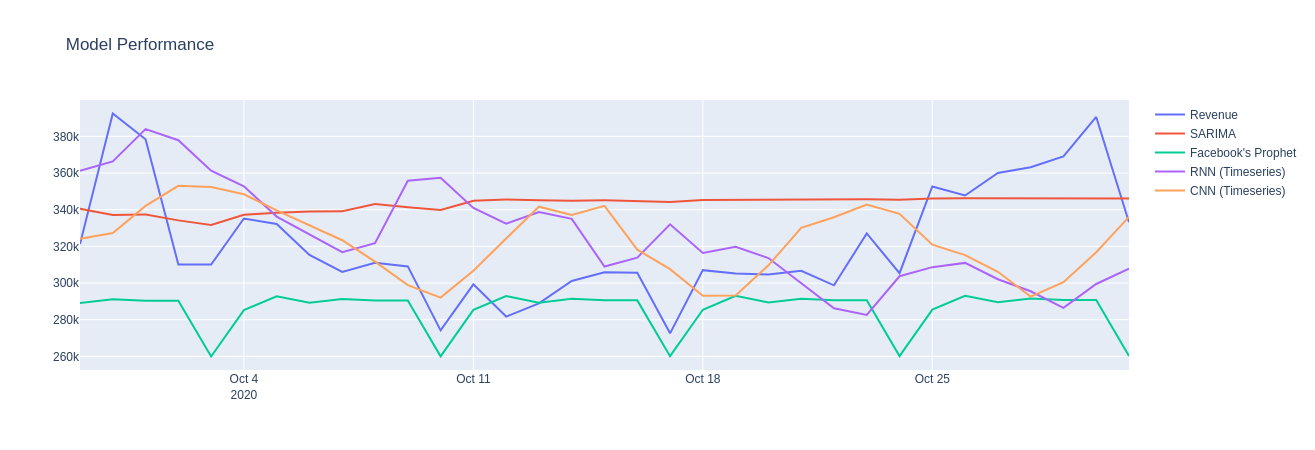

In [168]:
#Ploting results
fig = go.Figure()
fig.add_trace(go.Line(x=df.index[90:],y=df["Revenue"].iloc[90:],name="Revenue"))
fig.add_trace(go.Line(x=sarima_predictions.index,y=sarima_predictions,name="SARIMA"))
fig.add_trace(go.Line(x=prophet_forecast["ds"].iloc[90:],y=prophet_forecast["yhat"].iloc[90:],name="Facebook's Prophet"))
fig.add_trace(go.Line(x=df_tf.index[90:],y=tf_inverted_preds.flatten(),name="RNN (Timeseries)"))
fig.add_trace(go.Line(x=df_tf.index[90:],y=conv_inverted_preds.flatten(),name="CNN (Timeseries)"))
fig.update_layout(title="Model Performance")
fig.show()

### MSE and RMSE for each model

In [160]:
from sklearn.metrics import mean_squared_error

In [161]:
real_values = df['Revenue'].iloc[90:]

mse_sarima = mean_squared_error(real_values,sarima_predictions)

In [162]:
mse_fb = mean_squared_error(real_values,prophet_forecast["yhat"].iloc[90:])

In [163]:
mse_rnn = mean_squared_error(real_values,tf_inverted_preds.flatten())

In [164]:
mse_cnn = mean_squared_error(real_values,conv_inverted_preds.flatten())

In [165]:
rmse_sarima = np.sqrt(mse_sarima)
rmse_fb = np.sqrt(mse_fb)
rmse_rnn = np.sqrt(mse_rnn)
rmse_cnn = np.sqrt(mse_cnn)

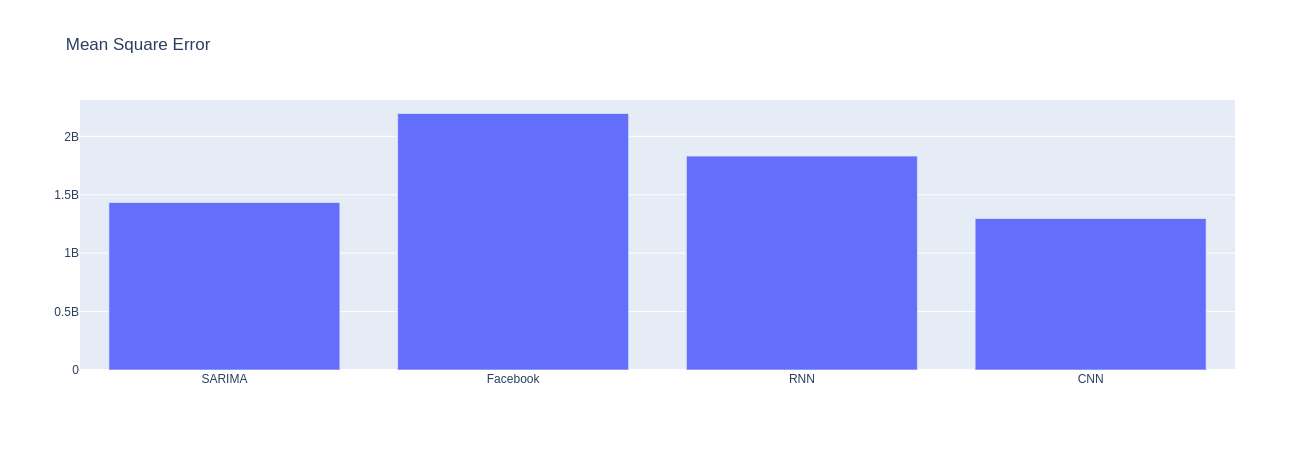

In [166]:
#Ploting results
fig = go.Figure()
fig.add_trace(go.Bar(x=["SARIMA","Facebook","RNN","CNN"],y=[mse_sarima,mse_fb,mse_rnn,mse_cnn]))
fig.update_layout(title="Mean Square Error")
fig.show()

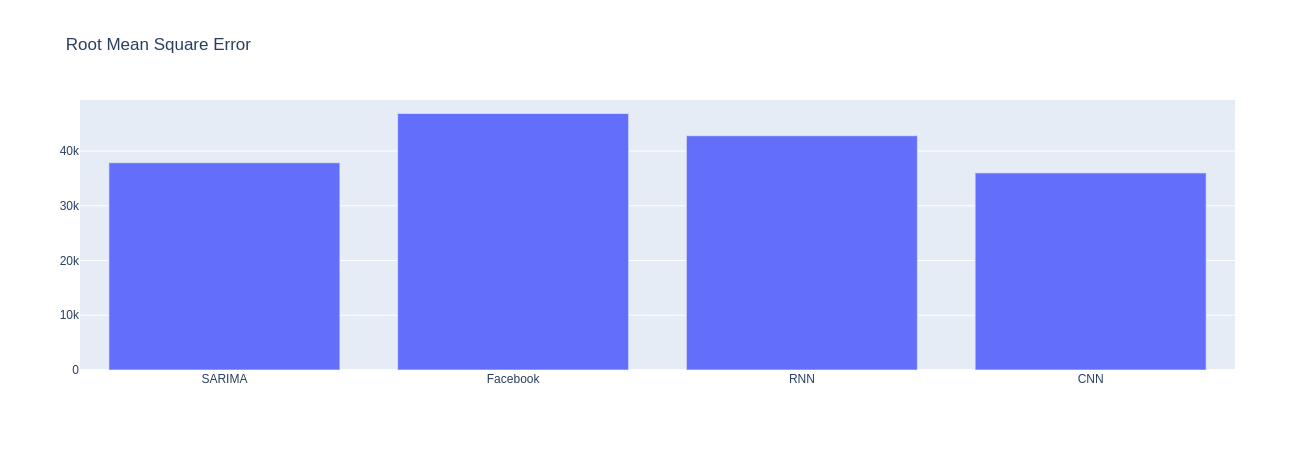

In [167]:
#Ploting results
fig = go.Figure()
fig.add_trace(go.Bar(x=["SARIMA","Facebook","RNN","CNN"],y=[rmse_sarima,rmse_fb,rmse_rnn,rmse_cnn]))
fig.update_layout(title="Root Mean Square Error")
fig.show()